In [1]:
import os
from IPython.display import Audio
import dotenv
import torch
from torchaudio import load
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from hydra.utils import instantiate
from hydra import compose, initialize
import pytorch_lightning as pl
from omegaconf import DictConfig, open_dict
from audio_diffusion_pytorch import DiffusionModel, UNetV0, VDiffusion, VSampler

from train.main.models import get_default_diffgen

In [2]:
# optional init via hydra
os.chdir("train")
initialize(version_base=None, config_path="train", job_name="test_app")
cfg = compose(config_name="config")
# cfg = compose(config_name="exp/diff_gen", 
#                         overrides=["+meta_dir=/data/meta", 
#                                    "num_workers=2", 
#                                    "prefetch_factor=2",
#                                    "+seed=12345"])

In [3]:
datamodule = instantiate(cfg.datamodule)
xeno_canto = instantiate(cfg.datamodule.datasets[0])
bergman = instantiate(cfg.datamodule.datasets[1])

In [4]:
datamodule.stratify

False

In [5]:
counts = dict()
for _, labels in tqdm(datamodule.train_dataloader()):
    for label in labels:
        name = label.split(";")[0]
        if name in counts:
            counts[name] += 1
        else:
            counts[name] = 1

  1%|          | 56/9781 [00:44<2:07:36,  1.27it/s]


KeyboardInterrupt: 

1792


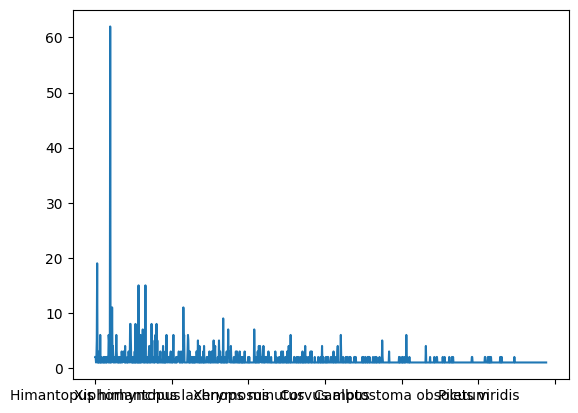

In [6]:
# not stratified
counts = pd.Series(counts)
counts.plot()
print(counts.sum())

2112


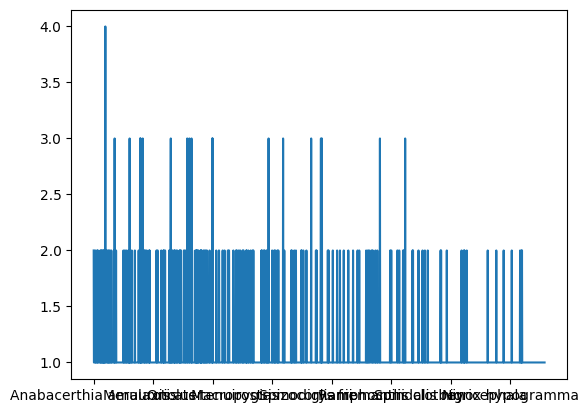

In [12]:
# with stratified sampling
counts = pd.Series(counts)
counts.plot()
print(counts.sum())

In [3]:
model = instantiate(cfg.model)
print(type(model))  # training wrapper
print(type(model.model))
print(type(model.ema.ema_model)) #use for inference

<class 'main.models.DiffGen'>
<class 'audio_diffusion_pytorch.models.DiffusionModel'>
<class 'audio_diffusion_pytorch.models.DiffusionModel'>


## Load diffgen from training checkpoint

In [4]:
ckpt_dir = "/data/logs/ckpts/2024-01-11-15-18-08/epoch=57-valid_loss=0.036.ckpt"
ckpt = torch.load(ckpt_dir)
print(model.load_state_dict(ckpt["state_dict"]))
diffgen = model.ema.ema_model

<All keys matched successfully>


## Load diffgen from state_dict

In [5]:
diffgen_path = "/data/logs/ckpts/diffgen_v3"
torch.save(diffgen.state_dict(), diffgen_path)
diffgen = get_default_diffgen(state_dict_file=diffgen_path)

### Model Testing

In [13]:
device = "cuda:0"
diffgen.eval().to(device)
print(type(diffgen))

<class 'audio_diffusion_pytorch.models.DiffusionModel'>


In [8]:
#2**21 == 2048 * 32/2 * 64
noise = torch.randn(2, 32, 2048).cuda()
embedding = model.get_text_embeddings(["Xiphorhynchus chunchotambo; morning; December; 2013; Perú; 3 of 5; call", "this is just a test"]).cuda()
with torch.no_grad():
    waveform = diffgen.sample(noise, num_steps=100, embedding=embedding)
    print(waveform.shape)

torch.Size([2, 32, 2048])


In [11]:
# diffgen is a ddim and therefor deterministic
with torch.no_grad():
    w1 = diffgen.sample(noise, num_steps=10, embedding=embedding)
    w2 = diffgen.sample(noise, num_steps=10, embedding=embedding)

print((w1 == w2).all())

tensor(True, device='cuda:0')


In [71]:
latent = torch.randn(1, 32, 512).to(device)
embedding = torch.randn(1, 128, 768).to(device)

In [73]:
loss = diffgen(latent, 
      embedding=embedding,
      embedding_mask_proba=0.1,
     )
loss

tensor(1.5513, device='cuda:0', grad_fn=<MseLossBackward0>)

### Testing dataload

In [5]:
iterator = iter(datamodule.test_dataloader())
for i in range(10):
    batch = next(iterator)
    waveforms, labels = batch

    if i == 0: print(labels)
    print(waveforms.shape)
    print(type(labels))
    print(len(labels))

['Milvus migrans; morning; week 23; 2018; Россия; 18.2 seconds; 4 of 5; call; Corvus cornix; Mareca penelope', 'Cinnycerthia unirufa; morning; week 24; 2014; Perú; 7.8 seconds; 4 of 5; song; call', 'Lepidocolaptes falcinellus; morning; week 10; 2015; Brasil; 1.1 seconds; 3 of 5; song', 'Xiphorhynchus guttatus; afternoon; week 37; 1996; Ecuador; 7.5 seconds; 5 of 5; call', 'Rhipidura nigritorquis; morning; week 41; 2016; Philippines; 11.7 seconds; 4 of 5; song', 'Leptopoecile sophiae; ; week 20; 2007; Қазақстан; 19.1 seconds; 4 of 5; call; Mycerobas carnipes; Phylloscopus humei; Calliope pectoralis', 'Xiphocolaptes promeropirhynchus; ; week 10; 1996; Colombia; 17.2 seconds; 4 of 5', 'Myiarchus tyrannulus; afternoon; week 28; 2001; Brasil; 22.6 seconds; 5 of 5; call', 'Apus apus; night; week 27; 2017; Schweiz/Suisse/Svizzera/Svizra; 26.1 seconds; 3 of 5; call', 'Aegithalos concinnus; morning; week 08; 2021; 臺灣; 4.7 seconds; 4 of 5; call', 'Tarsiger cyanurus; afternoon; week 27; 2020; Sve